In [1]:
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy import stats
import joblib

#working directory (needed for saving models)
filepath_wd = ".../Resultate_final/working_directory/"
#directory for results
filepath = ".../Resultate_final/Put/saved_single_run/"

In [2]:
#Market and option parameters as in section 4.1 of 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
s_0 = 100
r = 0.01
mu = 0.05
sigma = 0.2
tau = 1/52
T = 1/3
K = 100

#Confidence levels and parameters for Value-at-Risk, Expected Shortfall and GlueVaR
alpha_VaR = 0.995
alpha_ES = 0.99
alpha_Glue = 0.95
beta_Glue = 0.995
omega_Glue = np.array([1/3,1/3])

In [3]:
#Sizes for training set, validation set, test set, and set size for Monte Carlo estimation of the risk measures
M_1 = 1500000
M_2 = 500000
M_3 = 500000
M_MC = 500000

In [4]:
#Function for calculating simulated values of S_tau and simulated payoffs P_T from simulations of a standard normal random variable
def data_gen(Z,V):
    #simulate S_tau under P
    S_tau = s_0 * np.exp( (mu-0.5*sigma**2)*tau + sigma*np.sqrt(tau)*Z)
    #Simulate S_T given S_tau under Q
    S_T = S_tau * np.exp( (r-0.5*sigma**2)*(T-tau) + sigma*np.sqrt(T-tau)*V)
    #Calculate corresponding simulated discounted payoffs
    P_T = np.exp(-r*(T-tau)) * np.maximum(K-S_T,0)
    return S_tau, P_T

#Function for the computation of GlueVaR
def GlueVaR(omega, L, alpha, beta):
    j_beta = int(len(L)*(1-beta))-1
    j_alpha = int(len(L)*(1-alpha))-1

    ES_beta = 1/(1-beta) * np.sum(L[0:j_beta-1])/len(L) + ( 1 - (j_beta-1)/((1-beta)*len(L)) )*L[j_beta]
    ES_alpha = 1/(1-alpha) * np.sum(L[0:j_alpha-1])/len(L) + ( 1 - (j_alpha-1)/((1-alpha)*len(L)) )*L[j_alpha]
    VaR_alpha = L[j_alpha]

    return omega[0]*ES_beta + omega[1]*ES_alpha + (1-omega[0]-omega[1])*VaR_alpha

In [5]:
#Generating simulations of standard normal random variables for training set, validation set, test set, set for Monte Carlo estimation of risk measures
Z_train = np.random.normal(loc=0, scale=1, size=M_1)
V_train = np.random.normal(loc=0, scale=1, size=M_1)
Z_val = np.random.normal(loc=0, scale=1, size=M_2)
V_val = np.random.normal(loc=0, scale=1, size=M_2)
Z_test = np.random.normal(loc=0, scale=1, size=M_3)
V_test = np.random.normal(loc=0, scale=1, size=M_3)
Z_MC = np.random.normal(loc=0, scale=1, size=M_MC)
V_MC = np.random.normal(loc=0, scale=1, size=M_MC)

#Calculate the risk factor S_tau and the corresponding simulated payoffs P_T
S_tau_train, P_T_train = data_gen(Z=Z_train, V=V_train)
S_tau_val, P_T_val = data_gen(Z=Z_val, V=V_val)
S_tau_test, P_T_test = data_gen(Z=Z_test, V=V_test)
S_tau_MC, P_T_MC = data_gen(Z=Z_MC, V=V_MC)

#Calculating the parts of the test set that fall into B_1 and B_2
s_40 = s_0 * np.exp( (mu-0.5*sigma**2)*tau + sigma*np.sqrt(tau)*stats.norm.ppf(0.4, loc=0, scale=1))
s_70 = s_0 * np.exp( (mu-0.5*sigma**2)*tau + sigma*np.sqrt(tau)*stats.norm.ppf(0.7, loc=0, scale=1))
B_1 = S_tau_test < s_40
B_2 = S_tau_test > s_70

#define and compile neural network model, setup as in section 4.1 of 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
bi = np.log( np.sum(P_T_train)/len(P_T_train))
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(1,)),
    tf.keras.layers.Dense(5, activation='tanh'),
    tf.keras.layers.Dense(1, activation='exponential', bias_initializer=tf.keras.initializers.Constant(value=bi))])
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

#function for saving models after each epoch for later evaluation
checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath_wd + "Put_saved_epoch_{epoch:01d}.hdf5", monitor='loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
#training of the neural network and saving models after each epoch
hist = model.fit(x=S_tau_train, y=P_T_train, epochs=40, batch_size=10000, validation_data=(S_tau_val,P_T_val), callbacks=[checkpoints])

#loading the saved models after every epoch
models_eval = []
for i in range(1,41):
    models_eval.append(tf.keras.models.load_model(filepath_wd + "Put_saved_epoch_" + str(i) + ".hdf5"))

#computation of the metrics (a), (b), (c) with B_1 and (c) with B_2
metric_a_NN = []
metric_b_NN = []
metric_c_B_1_NN = []
metric_c_B_2_NN = []
metric_c_B_1_NN = []
metric_c_B_2_NN = []
mse_train_NN = hist.history['mse'][-1]
mse_val_NN = hist.history['val_mse'][-1]

for j in range(40):
    P_T_pred_tmp = models_eval[j].predict(S_tau_test)[:,0]
    mc_tmp = P_T_pred_tmp - P_T_test
    metric_a_NN.append(np.sum(mc_tmp)/len(P_T_test))
    metric_b_NN.append(np.sum((mc_tmp)*P_T_pred_tmp)/len(P_T_test))
    metric_c_B_1_NN.append(np.sum(mc_tmp[B_1])/len(P_T_test))
    metric_c_B_2_NN.append(np.sum(mc_tmp[B_2])/len(P_T_test))

2021-11-09 15:37:21.470538: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-09 15:37:22.590963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30988 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0
2021-11-09 15:37:22.592602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30988 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0
2021-11-09 15:37:23.510883: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes a

Epoch 1/40
150/150 [==============================] - 1s 2ms/step - loss: 36.7575 - mse: 36.7575 - val_loss: 38.7934 - val_mse: 38.7934
Epoch 2/40
150/150 [==============================] - 0s 1ms/step - loss: 36.3582 - mse: 36.3582 - val_loss: 39.2968 - val_mse: 39.2968
Epoch 3/40
150/150 [==============================] - 0s 1ms/step - loss: 36.3293 - mse: 36.3293 - val_loss: 36.6824 - val_mse: 36.6824
Epoch 4/40
150/150 [==============================] - 0s 1ms/step - loss: 36.3154 - mse: 36.3154 - val_loss: 36.4013 - val_mse: 36.4013
Epoch 5/40
150/150 [==============================] - 0s 1ms/step - loss: 36.3071 - mse: 36.3071 - val_loss: 36.3765 - val_mse: 36.3765
Epoch 6/40
150/150 [==============================] - 0s 1ms/step - loss: 36.3018 - mse: 36.3018 - val_loss: 36.3747 - val_mse: 36.3747
Epoch 7/40
150/150 [==============================] - 0s 1ms/step - loss: 36.2989 - mse: 36.2989 - val_loss: 36.3711 - val_mse: 36.3711
Epoch 8/40
150/150 [============================

In [6]:
#Grid search algorithm for finding the best possible hyperparameters for the random forest
min_samples_leaf_list = [50,100,250,500,750,1250,1500,1750,2000]
score_list = []

opt_param = 0
opt_score = np.inf

for min_samples_leaf in min_samples_leaf_list:
    rfr = RandomForestRegressor(n_estimators=160, min_samples_leaf=min_samples_leaf, bootstrap=True, criterion='squared_error', verbose=0, n_jobs=-1)
    rfr.fit(X=S_tau_train.reshape(-1,1), y=P_T_train)
    score = mean_squared_error(y_true=P_T_val, y_pred=rfr.predict(S_tau_val.reshape(-1,1)))
    score_list.append(score)
    print('min_samples_leaf: ', min_samples_leaf, ', MSE: ', score)
    if score < opt_score:
        opt_param = min_samples_leaf
        opt_score = score
        print('New best!')

print('Best parameters found in grid search: ', opt_param, ' with MSE ', opt_score)

min_samples_leaf:  50 , MSE:  37.02055613370289
New best!
min_samples_leaf:  100 , MSE:  36.70050109097458
New best!
min_samples_leaf:  250 , MSE:  36.50911683943237
New best!
min_samples_leaf:  500 , MSE:  36.44050105088092
New best!
min_samples_leaf:  750 , MSE:  36.41297351760978
New best!
min_samples_leaf:  1250 , MSE:  36.39329404409599
New best!
min_samples_leaf:  1500 , MSE:  36.38793080791002
New best!
min_samples_leaf:  1750 , MSE:  36.38436223333792
New best!
min_samples_leaf:  2000 , MSE:  36.38203578863149
New best!
Best parameters found in grid search:  2000  with MSE  36.38203578863149


In [7]:
#trees will be added to the random forest consecutivly in these steps, i.e. steps of 40
n_tree_steps = []
for i in range(40,1001,40):
    n_tree_steps.append(int(i))

mse_train_RF = []
mse_val_RF = []
metric_a_RF= []
metric_b_RF = []
metric_c_B_1_RF = []
metric_c_B_2_RF = []
metric_c_B_1_RF = []
metric_c_B_2_RF = []

#definition of the random forest with optimal parameters from the tuning procedure
rfr = RandomForestRegressor(n_estimators=0, criterion='squared_error', min_samples_leaf=int(opt_param), bootstrap=True, verbose=0, warm_start=True, n_jobs=-1)

#training of the random forest by consecutively adding trees according to n_tree_steps and computation of metrics after each such step
for n in n_tree_steps:
    rfr.n_estimators = n
    rfr.fit(X=S_tau_train.reshape(-1,1), y=P_T_train)
    
    mse_train_RF.append(mean_squared_error(y_true=P_T_train, y_pred=rfr.predict(S_tau_train.reshape(-1,1))))
    mse_val_RF.append(mean_squared_error(y_true=P_T_val, y_pred=rfr.predict(S_tau_val.reshape(-1,1))))
    
    P_T_pred_tmp = rfr.predict(S_tau_test.reshape(-1,1))
    mc_tmp = P_T_pred_tmp - P_T_test
    metric_a_RF.append(np.sum(mc_tmp)/len(P_T_test))
    metric_b_RF.append(np.sum((mc_tmp)*P_T_pred_tmp)/len(P_T_test))
    metric_c_B_1_RF.append(np.sum(mc_tmp[B_1])/len(P_T_test))
    metric_c_B_2_RF.append(np.sum(mc_tmp[B_2])/len(P_T_test))
    print(n,'of',n_tree_steps[-1],'trees built')

40 of 1000 trees built
80 of 1000 trees built
120 of 1000 trees built
160 of 1000 trees built
200 of 1000 trees built
240 of 1000 trees built
280 of 1000 trees built
320 of 1000 trees built
360 of 1000 trees built
400 of 1000 trees built
440 of 1000 trees built
480 of 1000 trees built
520 of 1000 trees built
560 of 1000 trees built
600 of 1000 trees built
640 of 1000 trees built
680 of 1000 trees built
720 of 1000 trees built
760 of 1000 trees built
800 of 1000 trees built
840 of 1000 trees built
880 of 1000 trees built
920 of 1000 trees built
960 of 1000 trees built
1000 of 1000 trees built


In [8]:
#initialisation of risk measure estimators
VaR_hat_NN = []
ES_hat_NN = []
GlueVaR_hat_NN = []
VaR_hat_RF = []
ES_hat_RF = []
GlueVaR_hat_RF = []

#computation of option price depending on the risk factor S_tau according to the models, i.e. computation of L_hat_i's
L_hat_NN = model.predict(S_tau_MC)[:,0]
L_hat_RF = rfr.predict(S_tau_MC.reshape(-1,1))

#calculation of risk measures in a stepwise procedure
#number of steps
step_number = 200
#step size
i = M_MC/step_number

for n in range(1,step_number+1):
    #use first k simulations of L_hat
    k = int(n*i)
    
    #computation of risk measure estimators
    #sort observations
    L_hat_NN_sort = np.sort(L_hat_NN[0:k])[::-1]
    L_hat_RF_sort = np.sort(L_hat_RF[0:k])[::-1]

    #Value-at-Risk
    j_VaR = int(k*(1-alpha_VaR))-1
    VaR_hat_NN.append(L_hat_NN_sort[j_VaR])
    VaR_hat_RF.append(L_hat_RF_sort[j_VaR])

    #Expected Shortfall
    j_ES = int(k*(1-alpha_ES))-1
    ES_hat_NN.append(1/(1-alpha_ES) * np.sum(L_hat_NN_sort[0:j_ES-1])/k + ( 1 - (j_ES-1)/((1-alpha_ES)*k) )*L_hat_NN_sort[j_ES])
    ES_hat_RF.append(1/(1-alpha_ES) * np.sum(L_hat_RF_sort[0:j_ES-1])/k + ( 1 - (j_ES-1)/((1-alpha_ES)*k) )*L_hat_RF_sort[j_ES])
    
    #GlueVaR
    GlueVaR_hat_NN.append(GlueVaR(omega=omega_Glue, L=L_hat_NN_sort, alpha=alpha_Glue, beta=beta_Glue))
    GlueVaR_hat_RF.append(GlueVaR(omega=omega_Glue, L=L_hat_RF_sort, alpha=alpha_Glue, beta=beta_Glue))

Plots of the computed metrics a, b, c and training/validation MSEs for the neural network and the random forest with the evolving training process, i.e. the number of epochs or the number of trees added, respectively.

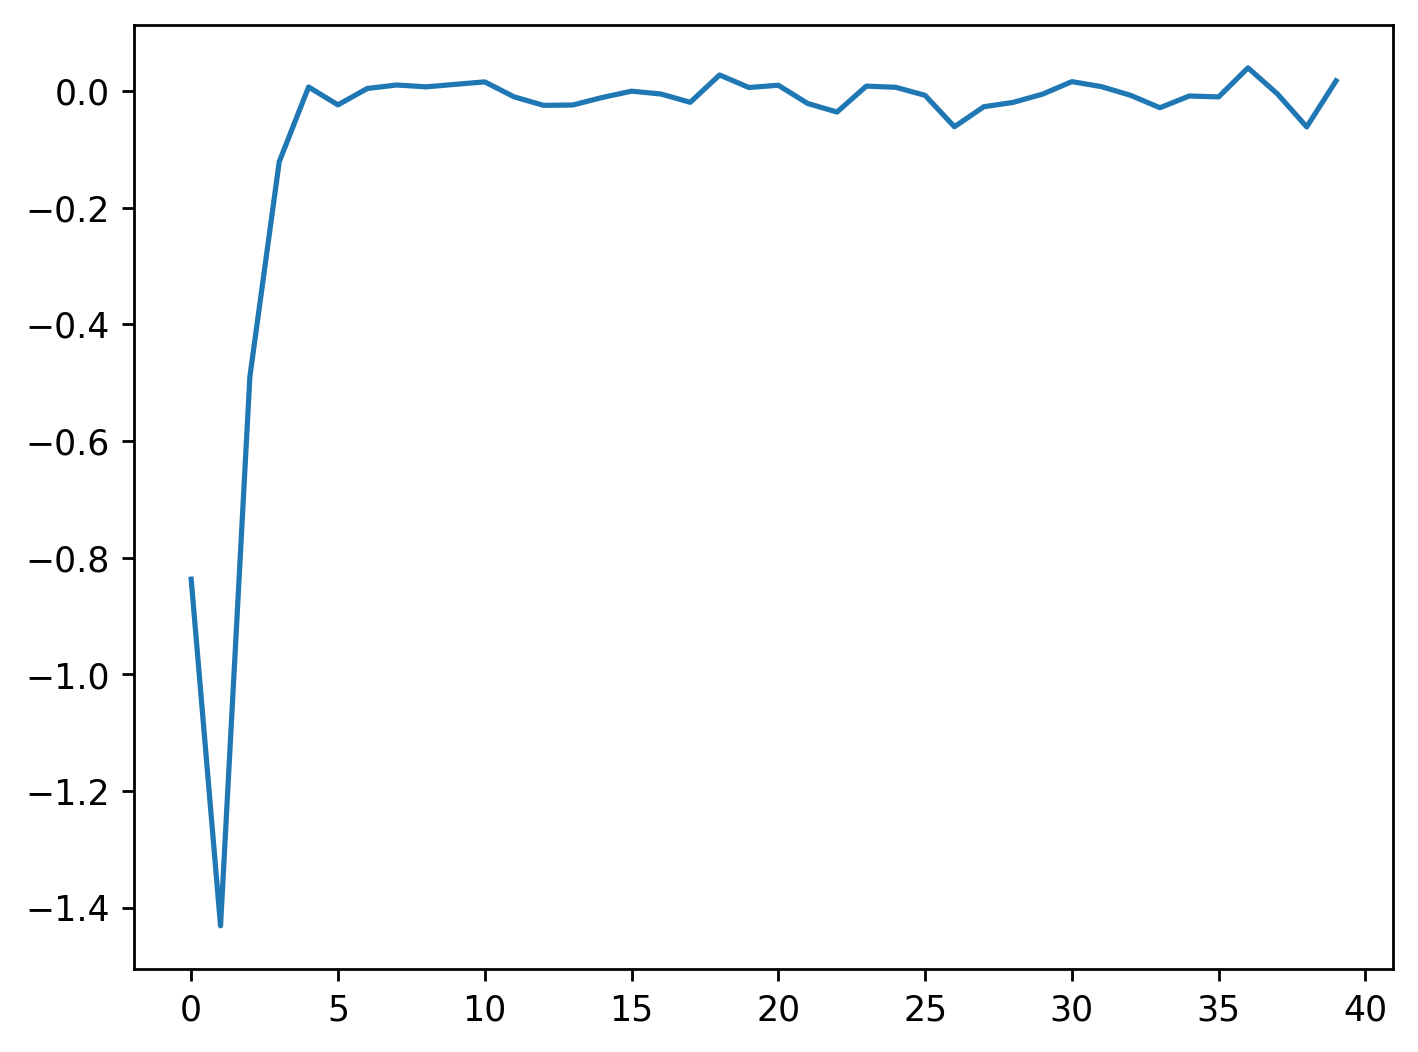

In [9]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),metric_a_NN, color='tab:blue')
plt.show()

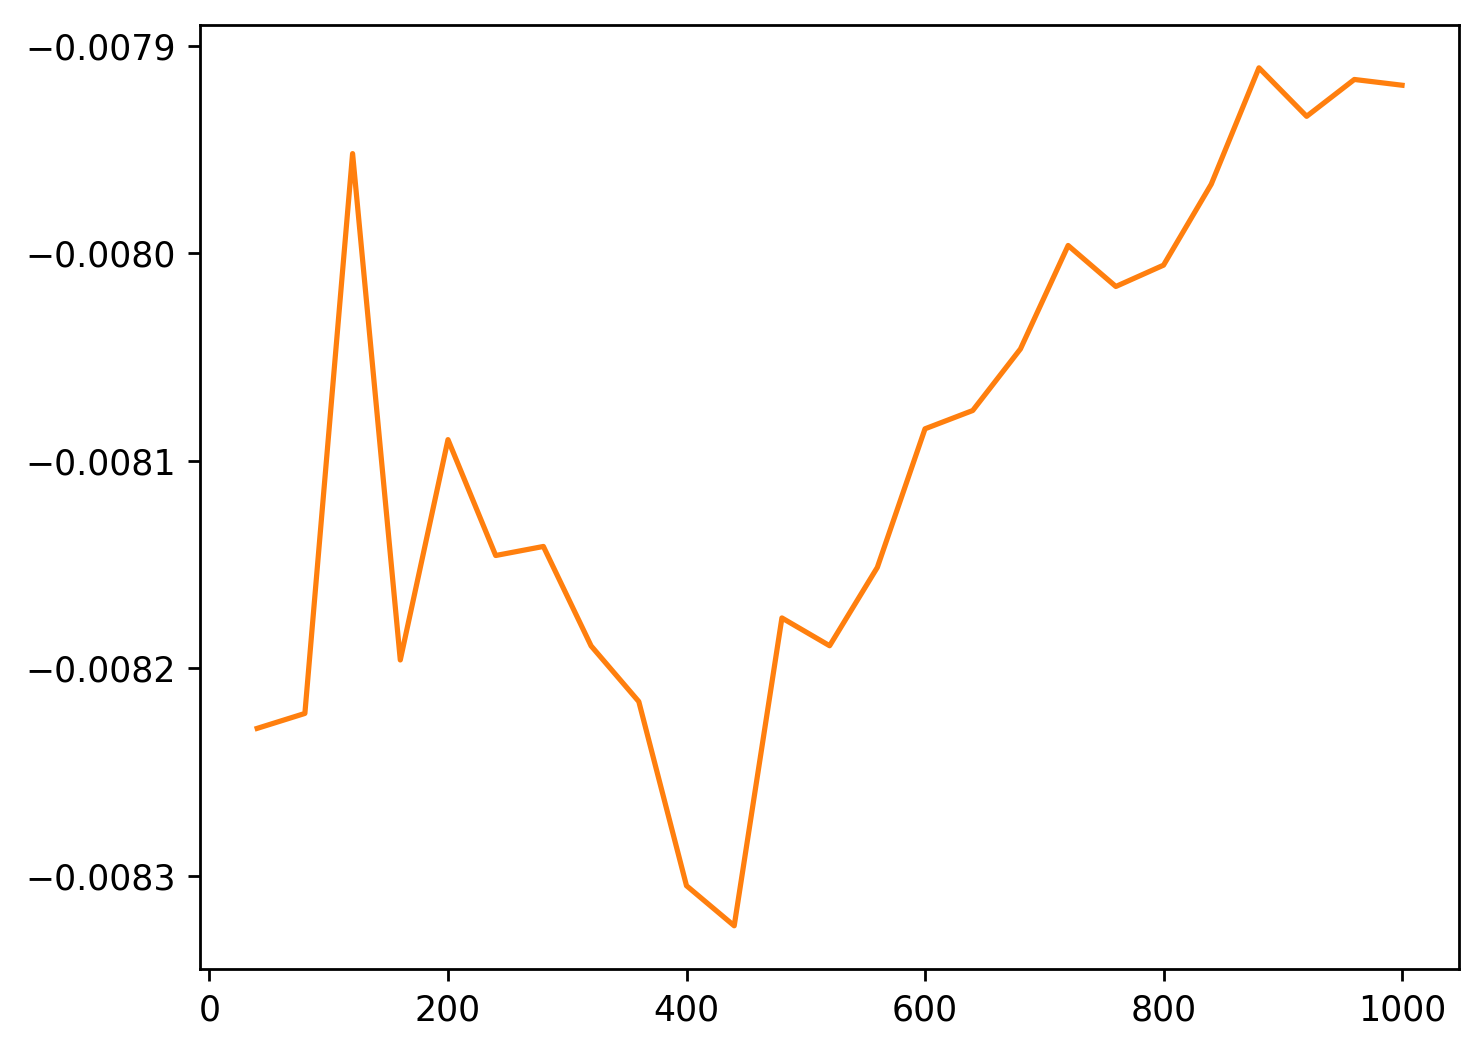

In [10]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_a_RF, color='tab:orange')
plt.show()

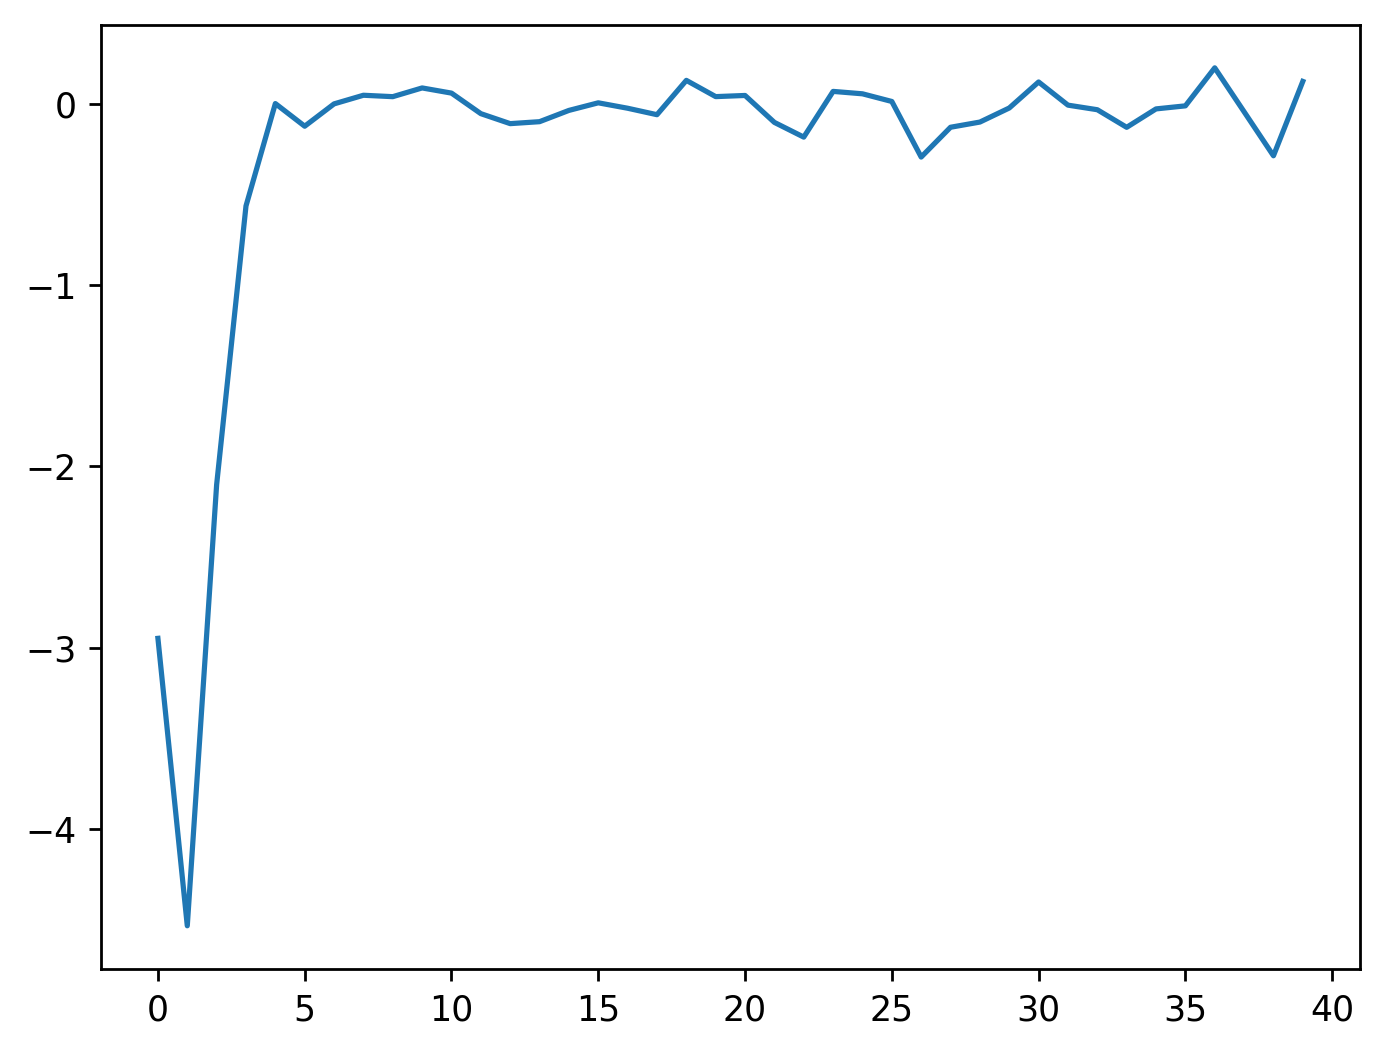

In [11]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),metric_b_NN, color='tab:blue')
plt.show()

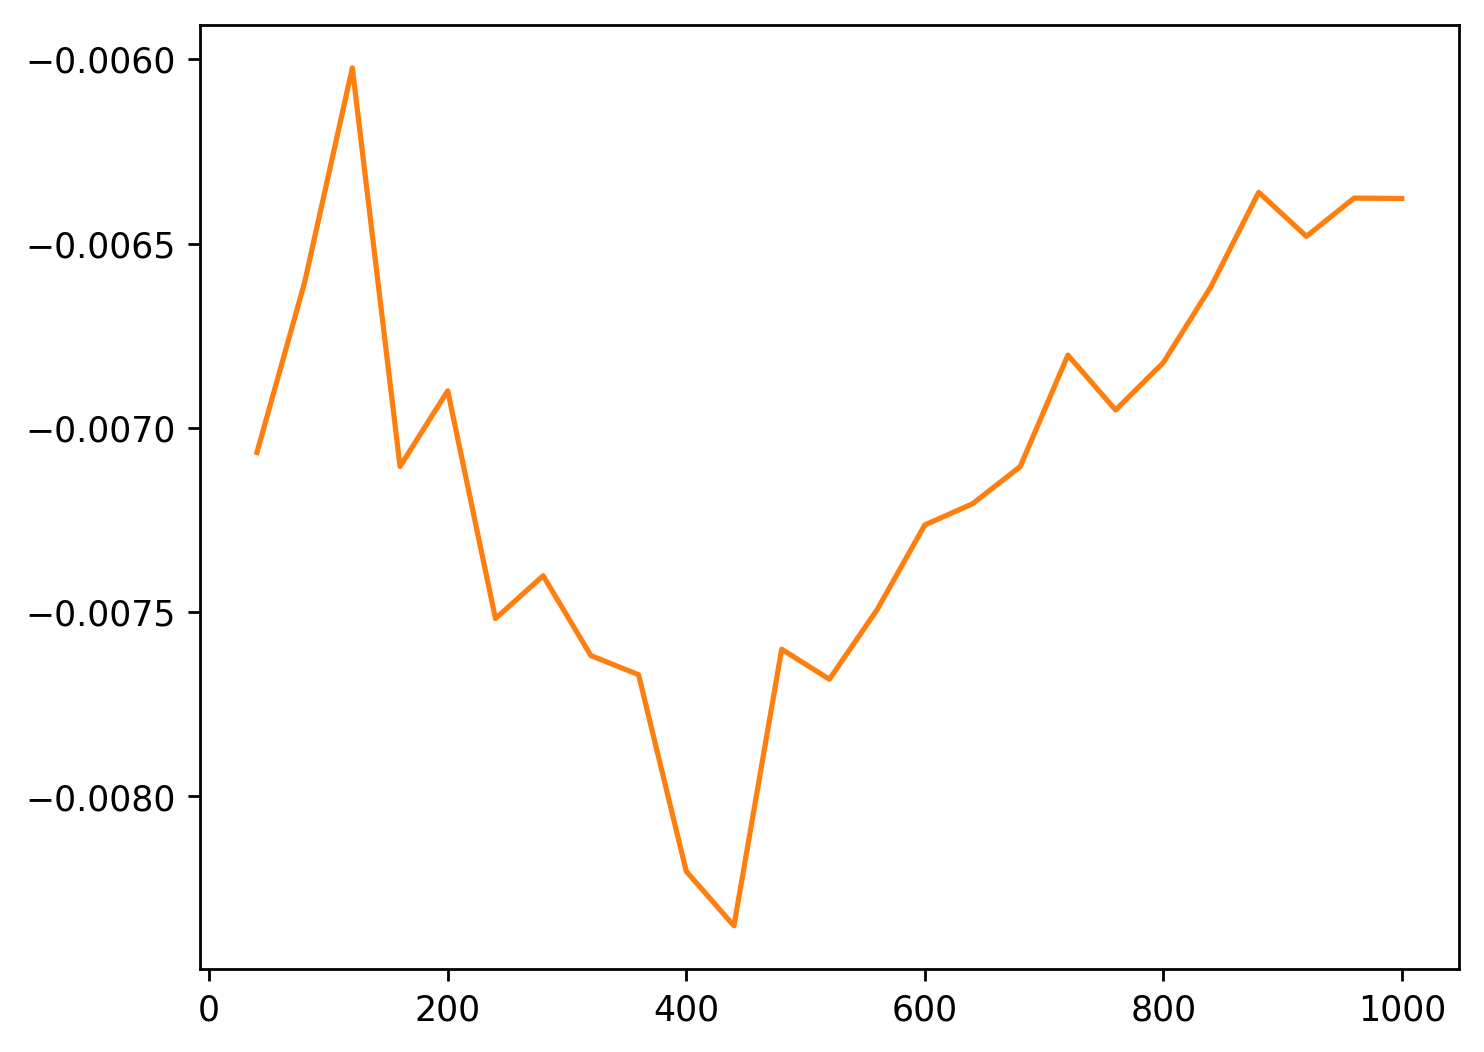

In [12]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_b_RF, color='tab:orange')
plt.show()

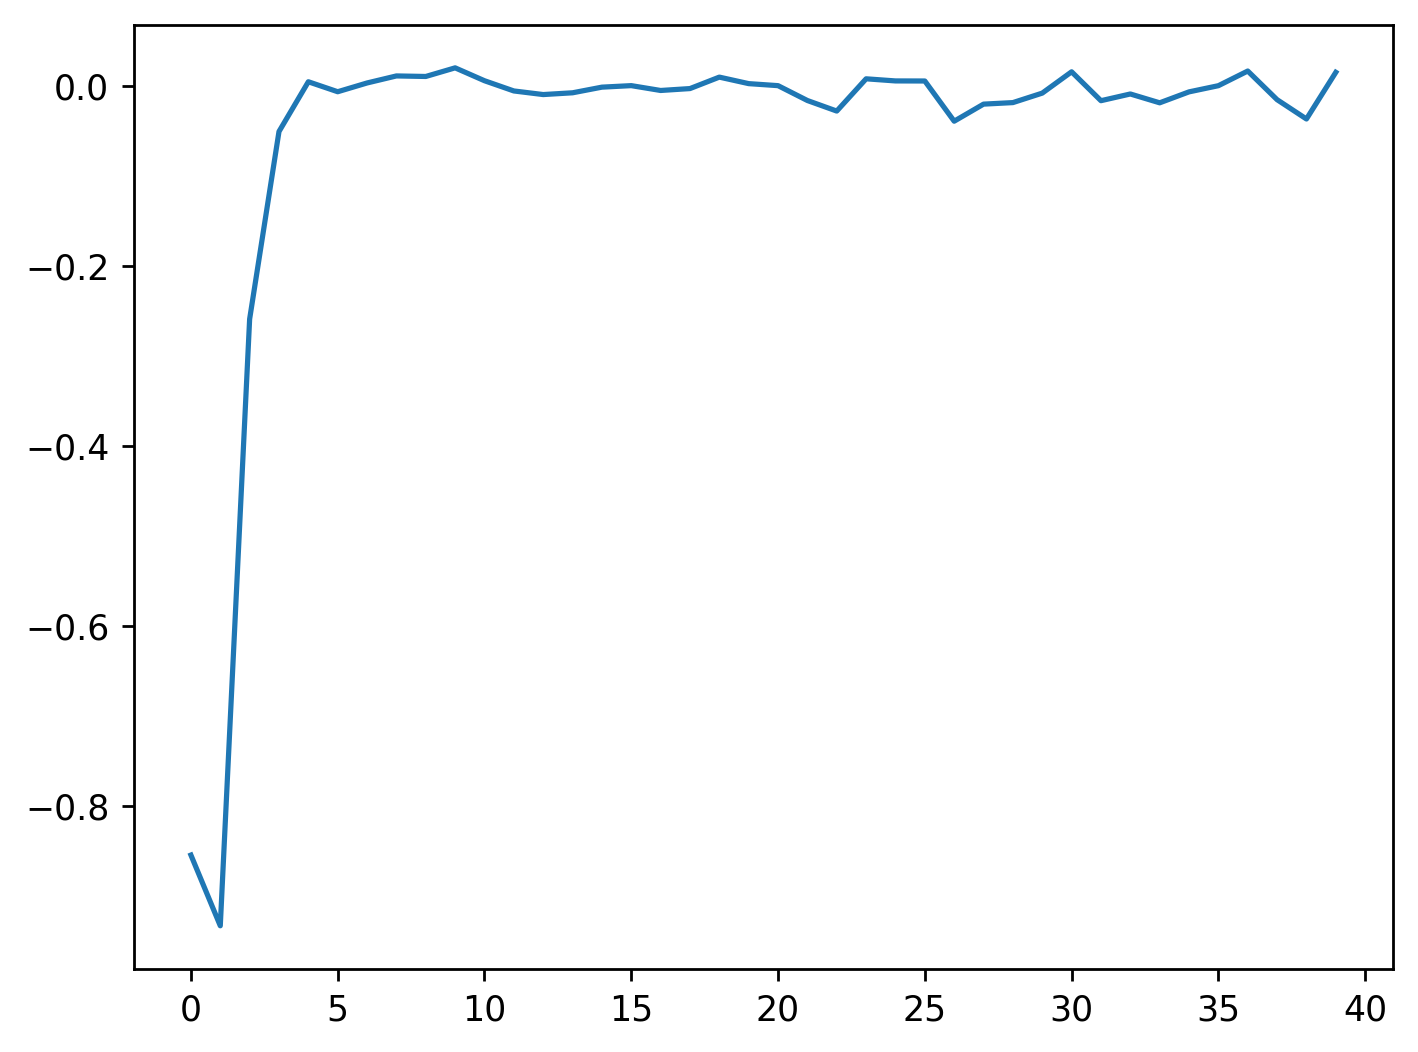

In [13]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),metric_c_B_1_NN, color='tab:blue')
plt.show()

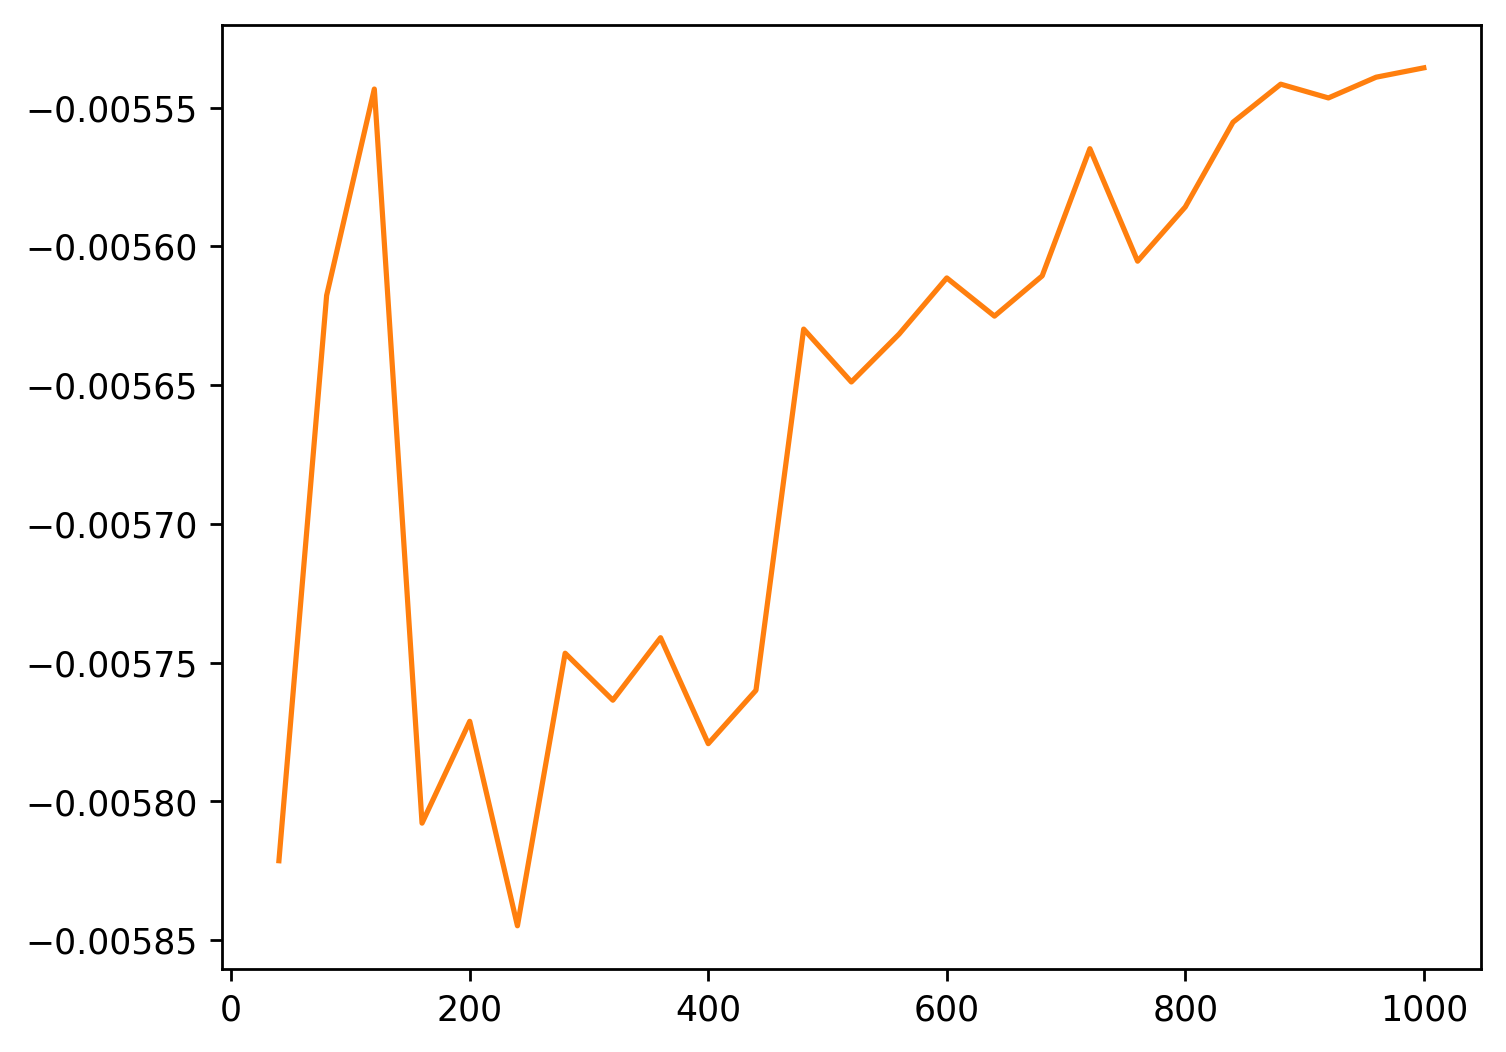

In [14]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_c_B_1_RF, color='tab:orange')
plt.show()

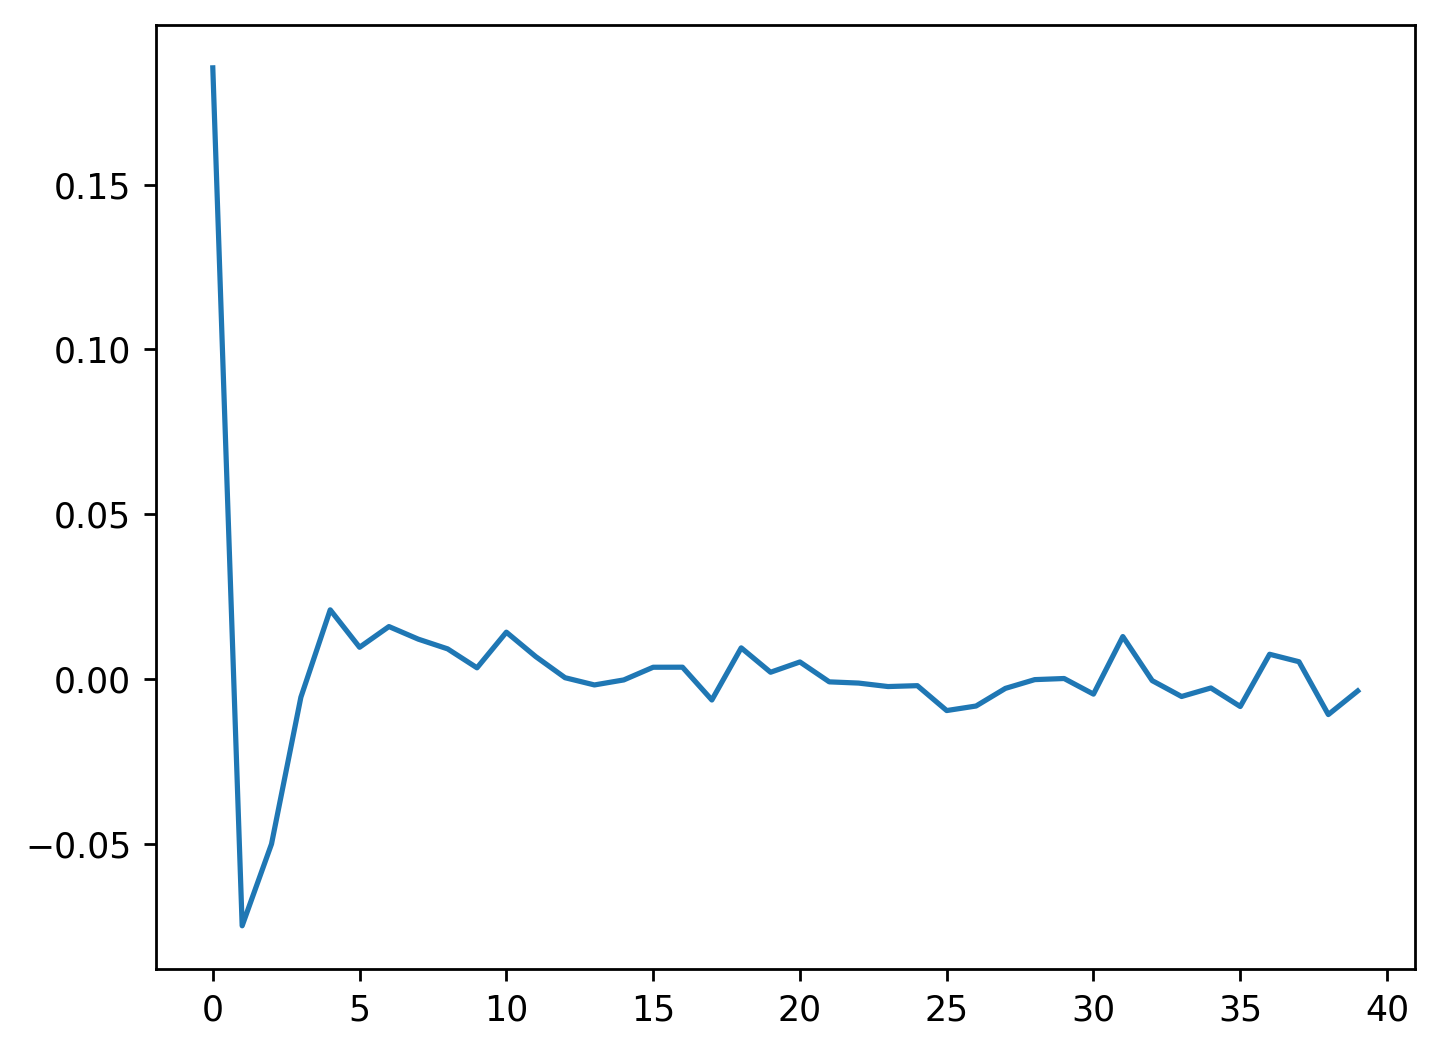

In [15]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),metric_c_B_2_NN, color='tab:blue')
plt.show()

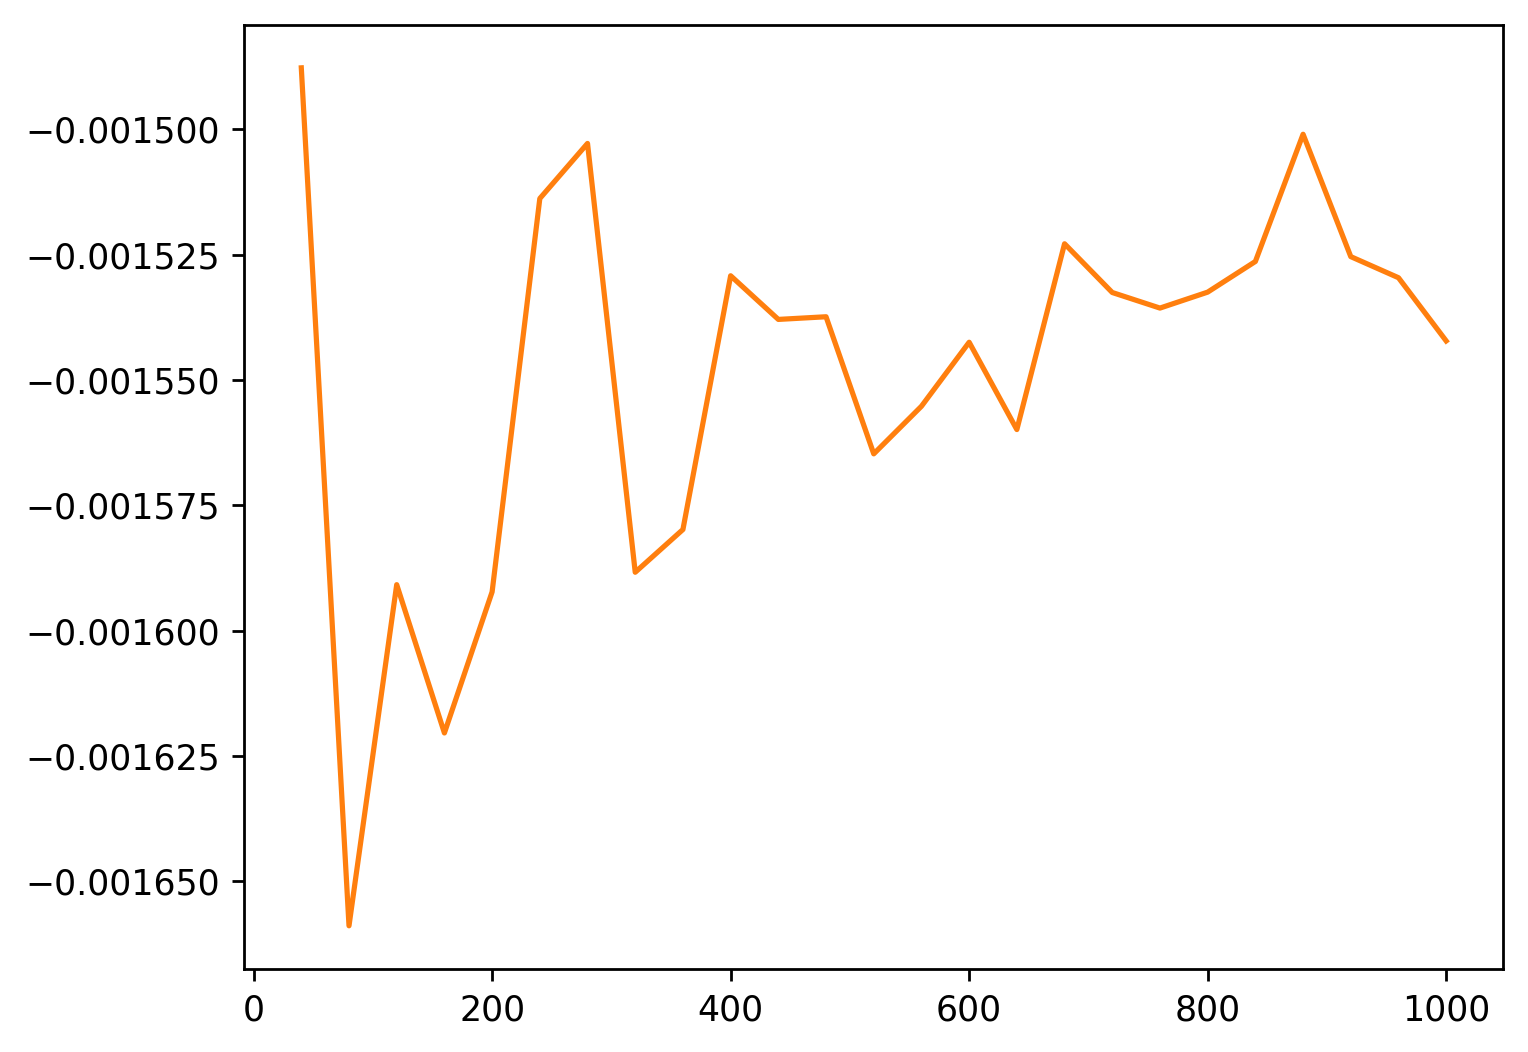

In [16]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_c_B_2_RF, color='tab:orange')
plt.show()

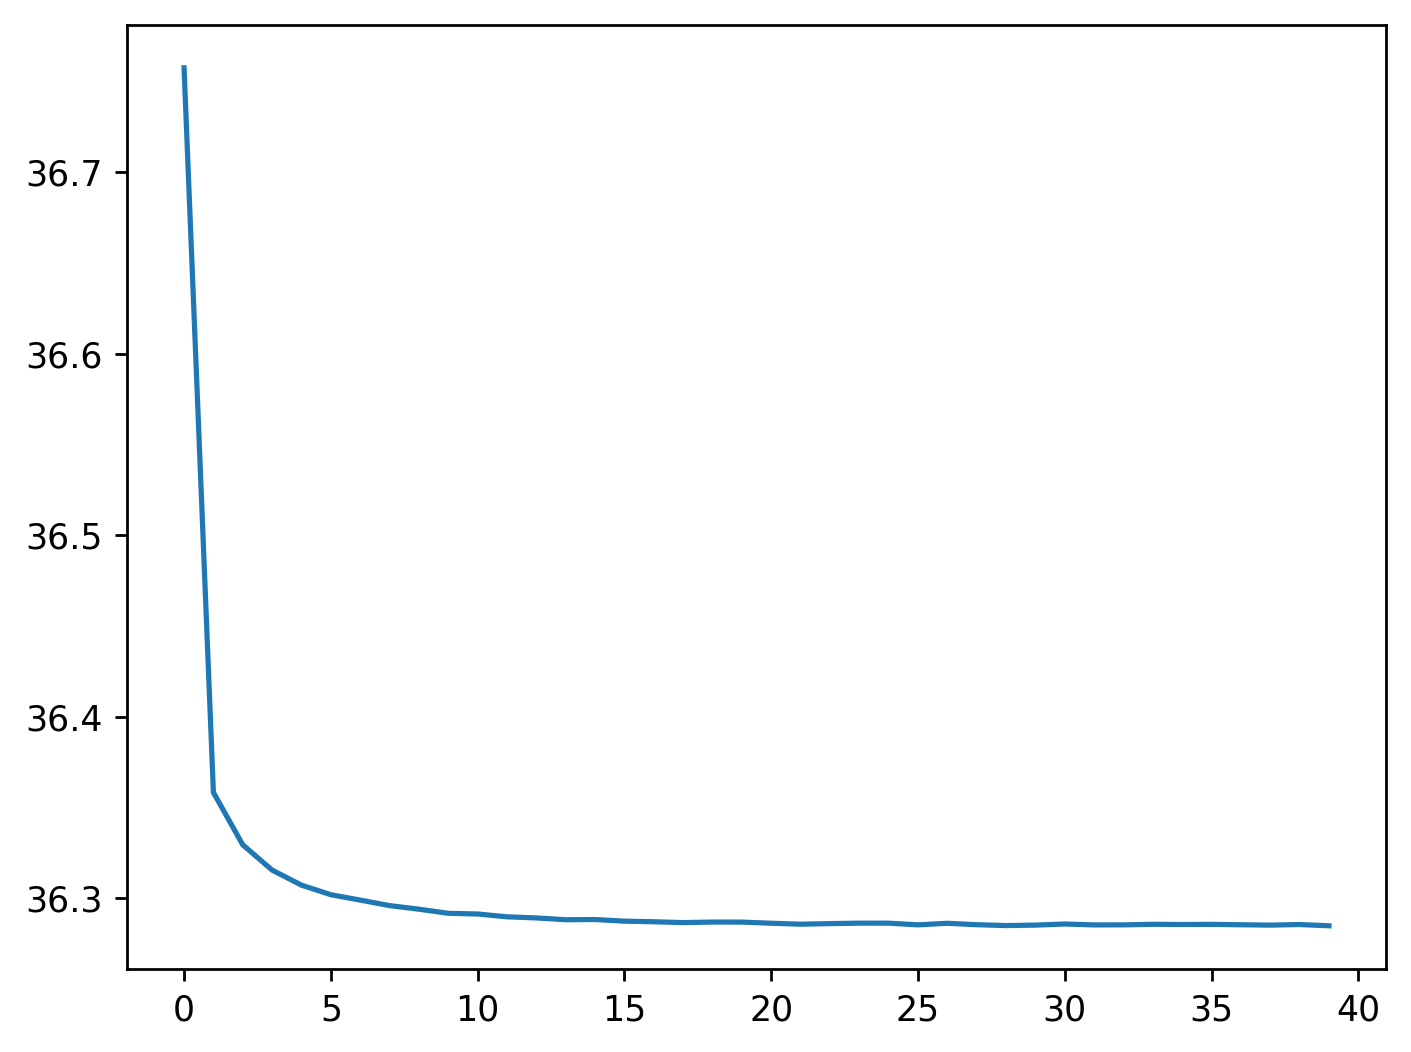

In [17]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),hist.history['mse'], color='tab:blue')
plt.show()

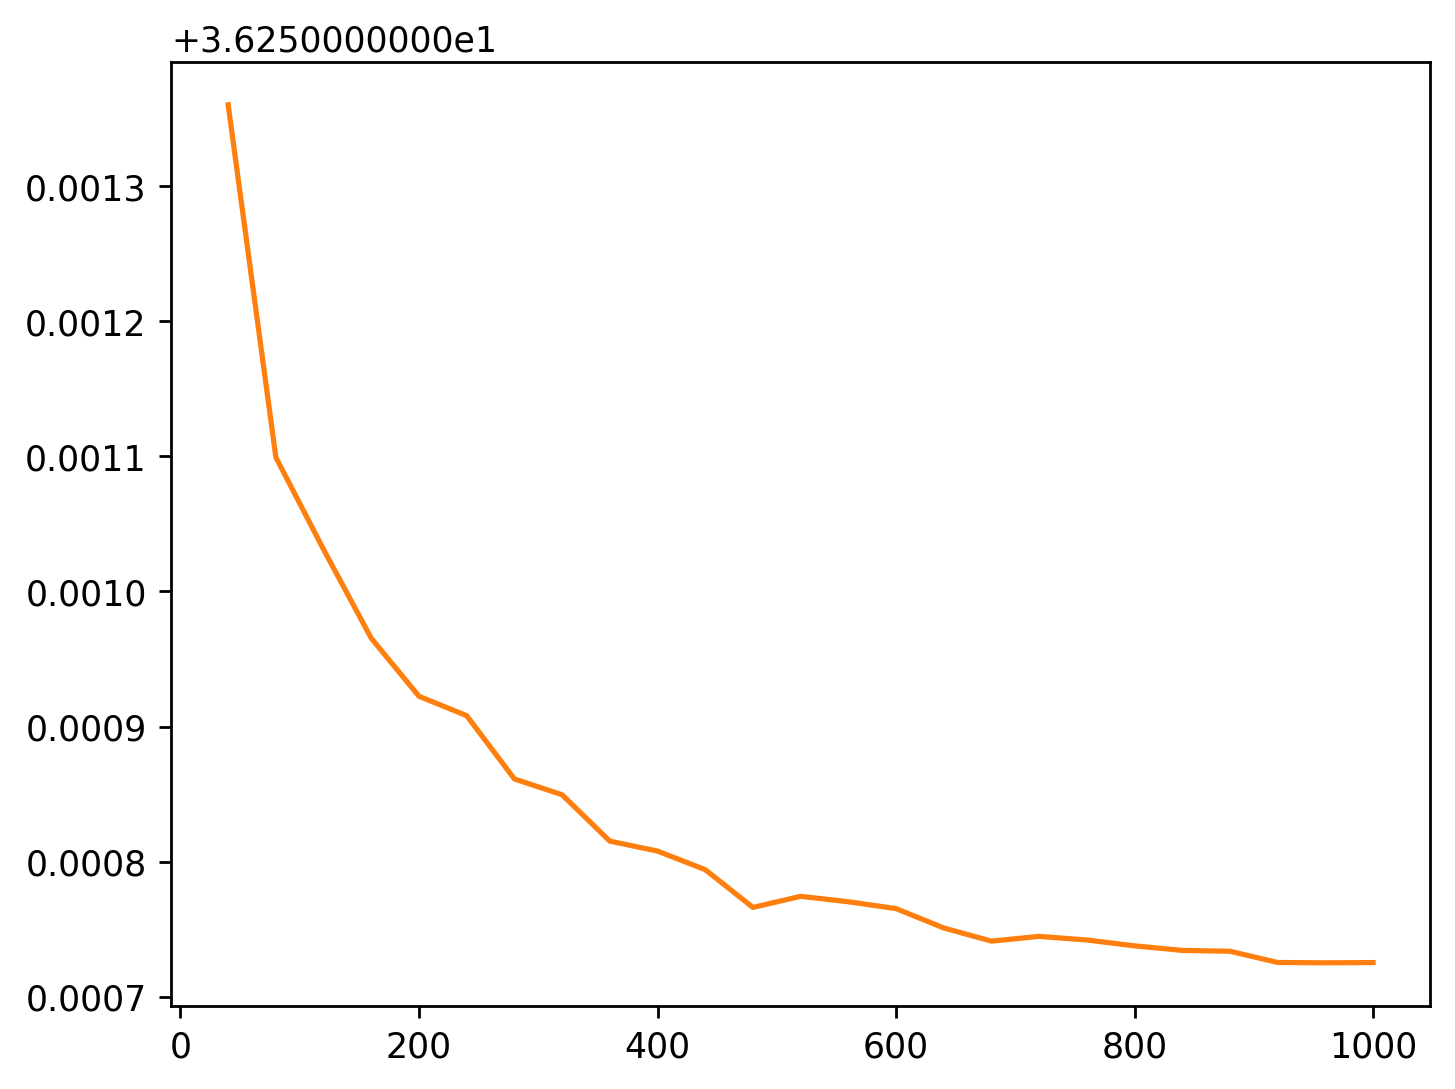

In [18]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,mse_train_RF, color='tab:orange')
plt.show()

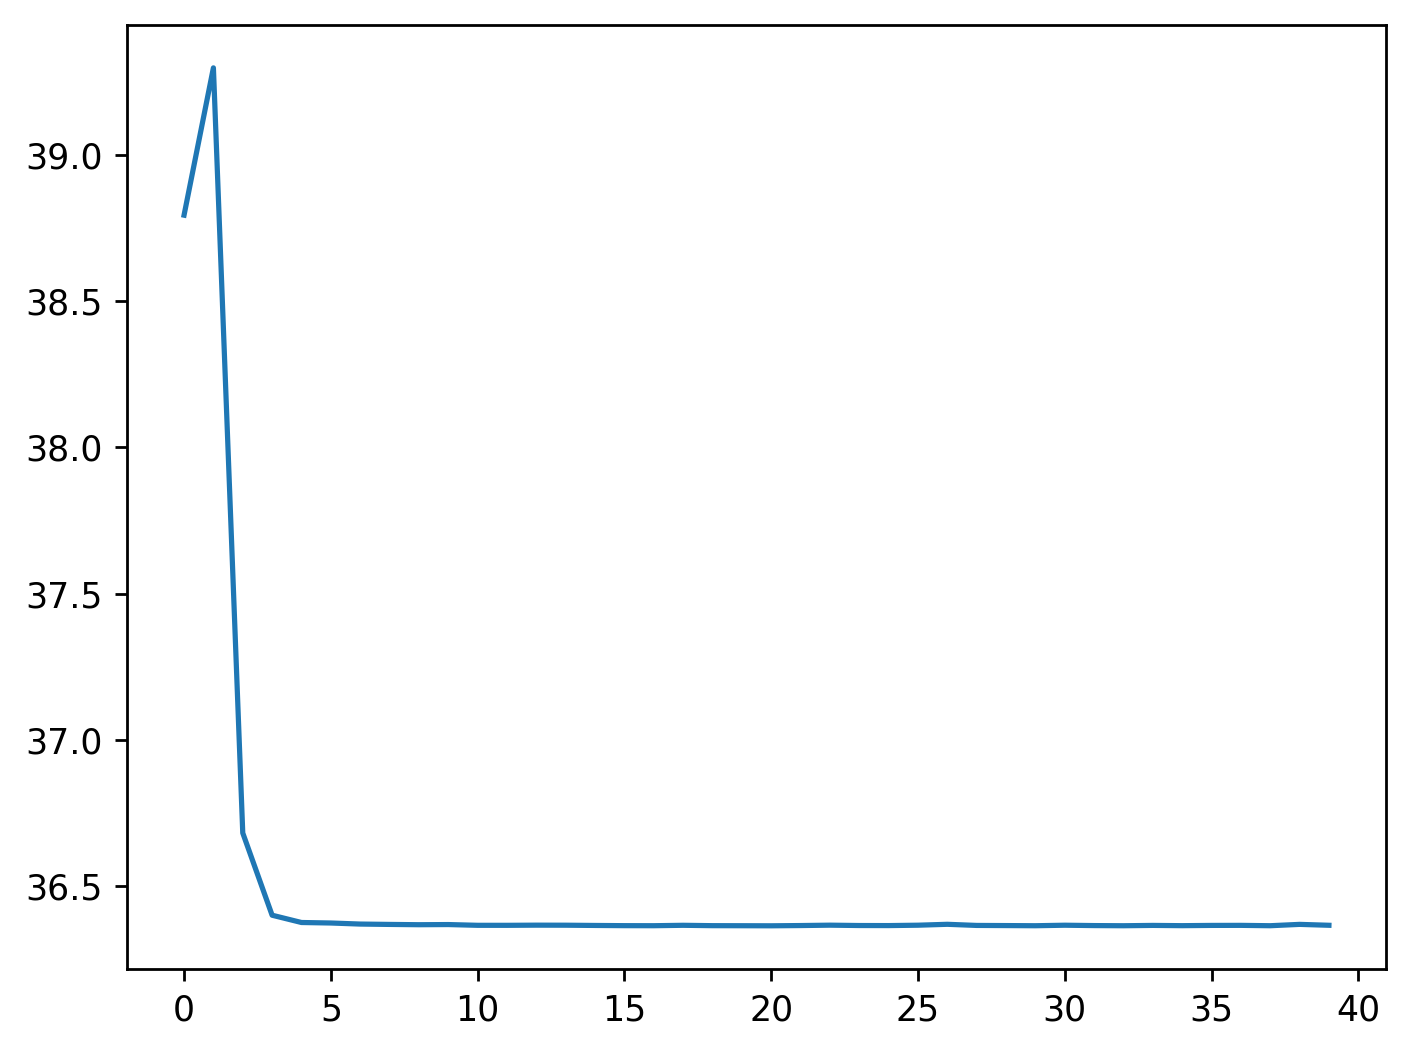

In [19]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),hist.history['val_mse'], color='tab:blue')
plt.show()

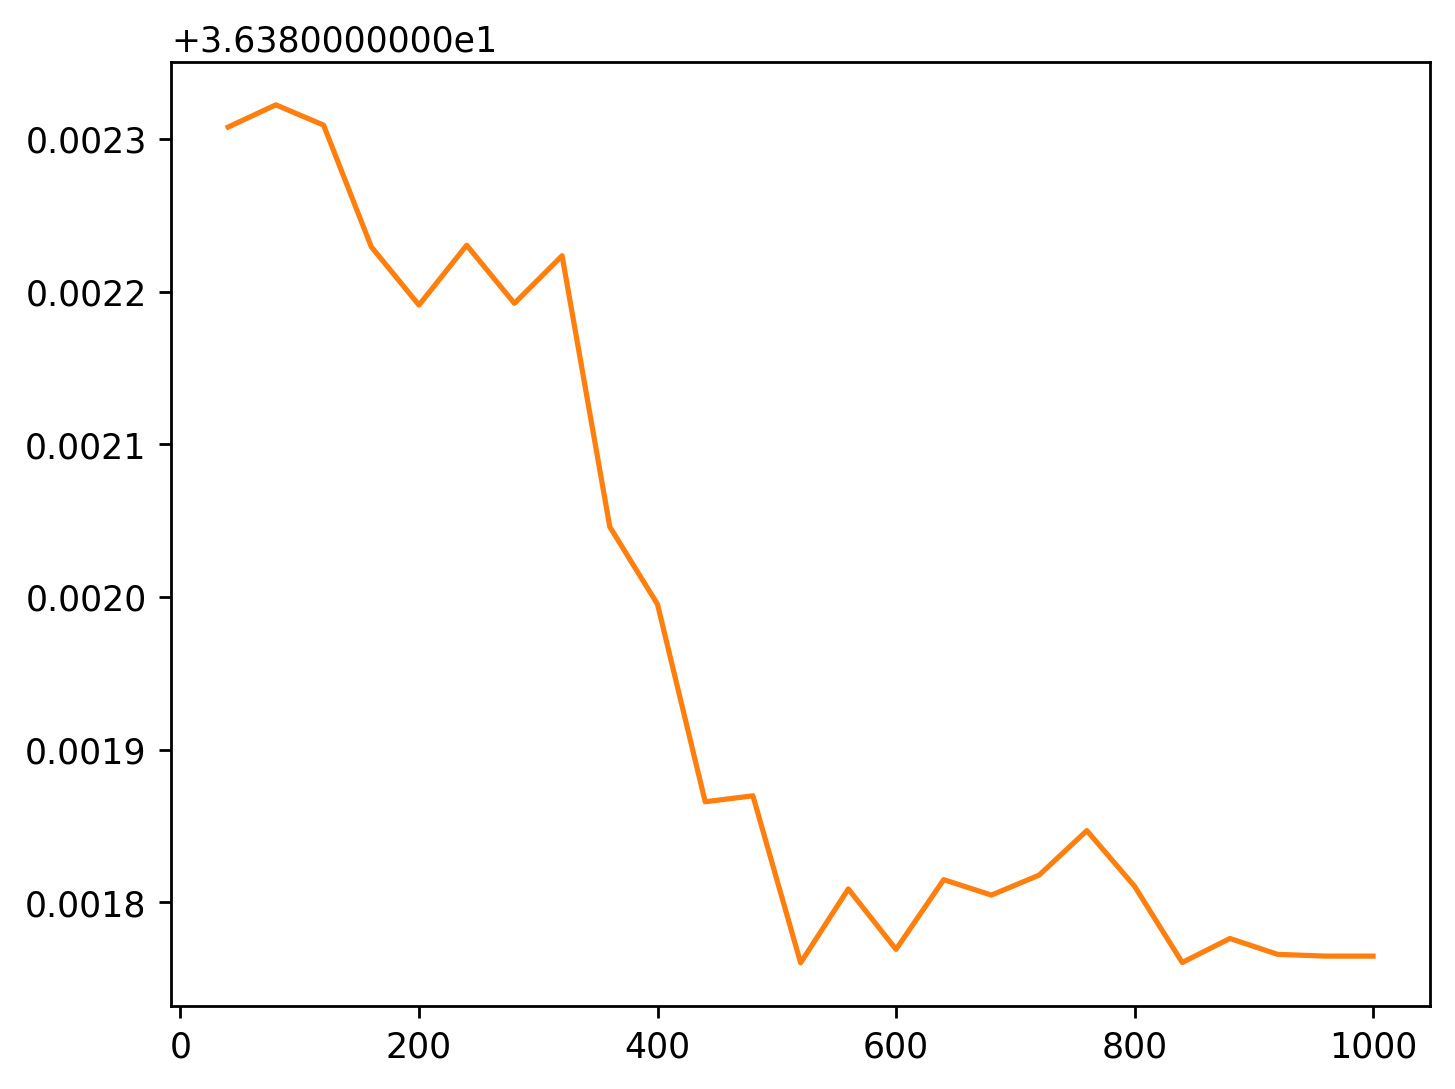

In [20]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,mse_val_RF, color='tab:orange')
plt.show()

Plots of the risk measure estimators calculated in the stepwise procedure.

In [21]:
steps = np.linspace(i, 500000, step_number)

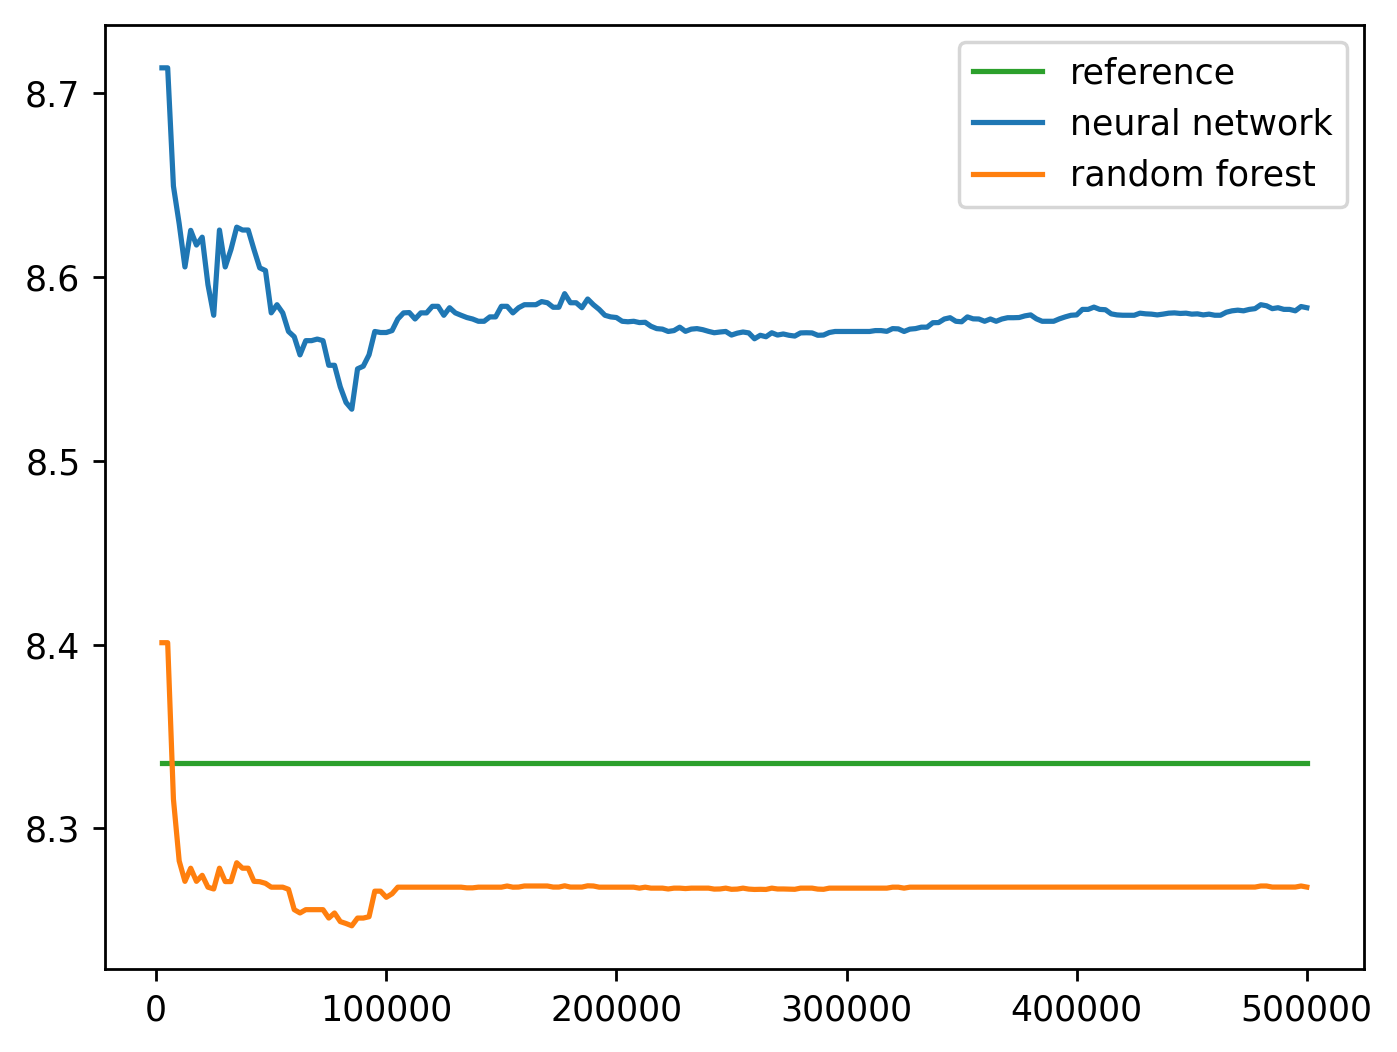

In [22]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(steps,np.full(len(steps),8.3356), color='tab:green')
plt.plot(steps,VaR_hat_NN, color='tab:blue')
plt.plot(steps,VaR_hat_RF, color='tab:orange')
plt.legend(['reference', 'neural network', 'random forest'])
plt.show()

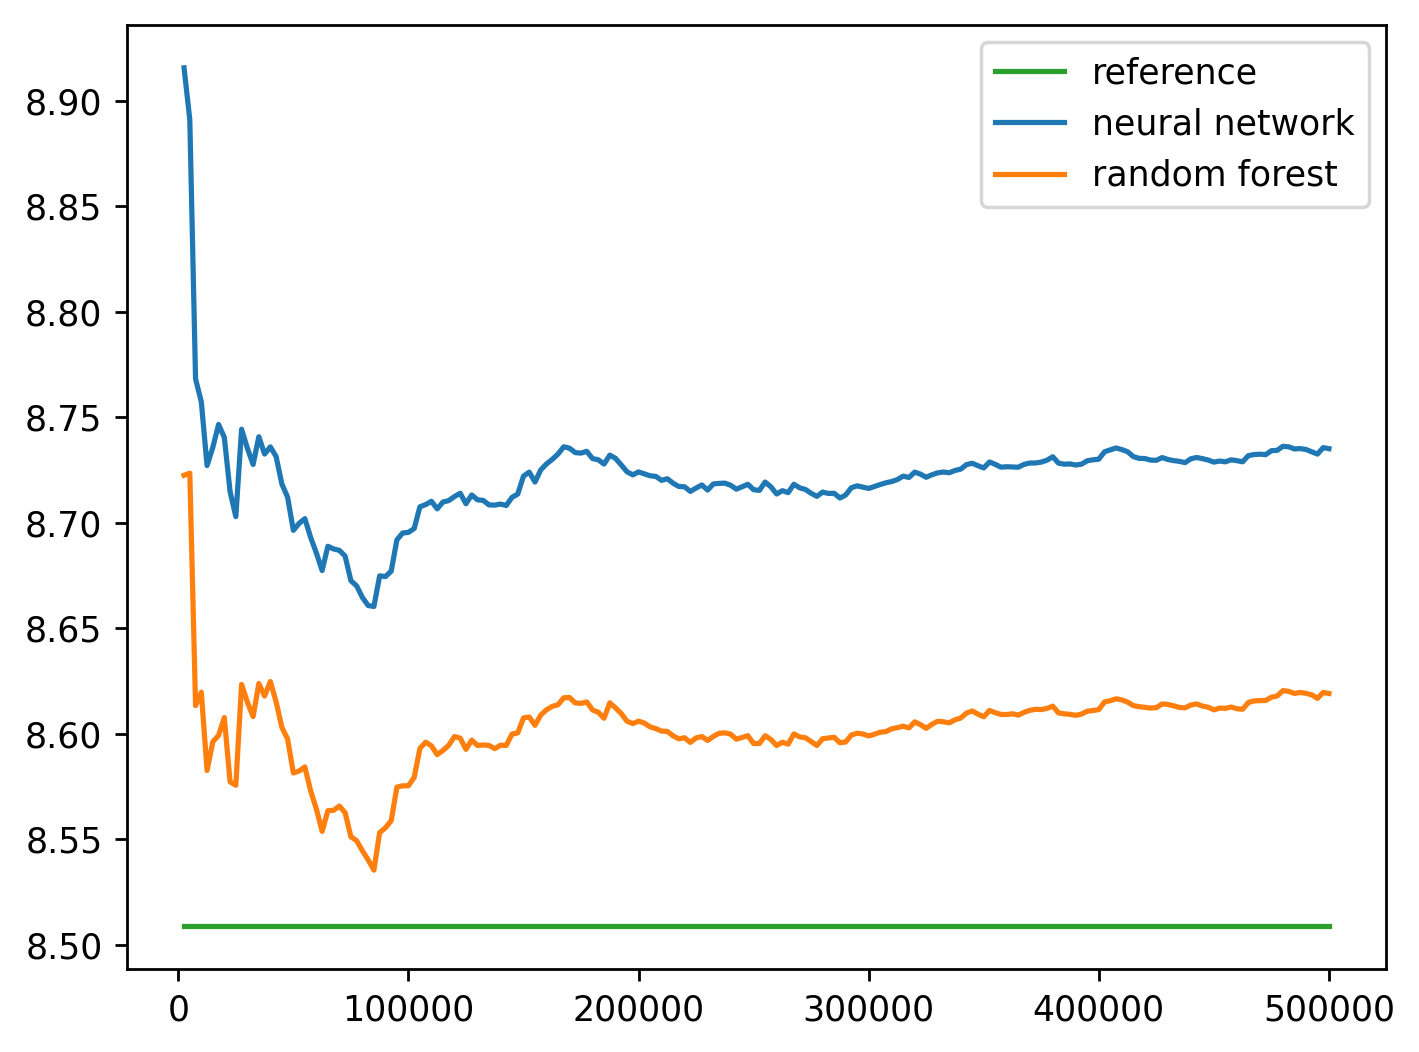

In [23]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(steps,np.full(len(steps),8.509), color='tab:green')
plt.plot(steps,ES_hat_NN, color='tab:blue')
plt.plot(steps,ES_hat_RF, color='tab:orange')
plt.legend(['reference', 'neural network', 'random forest'])
plt.show()

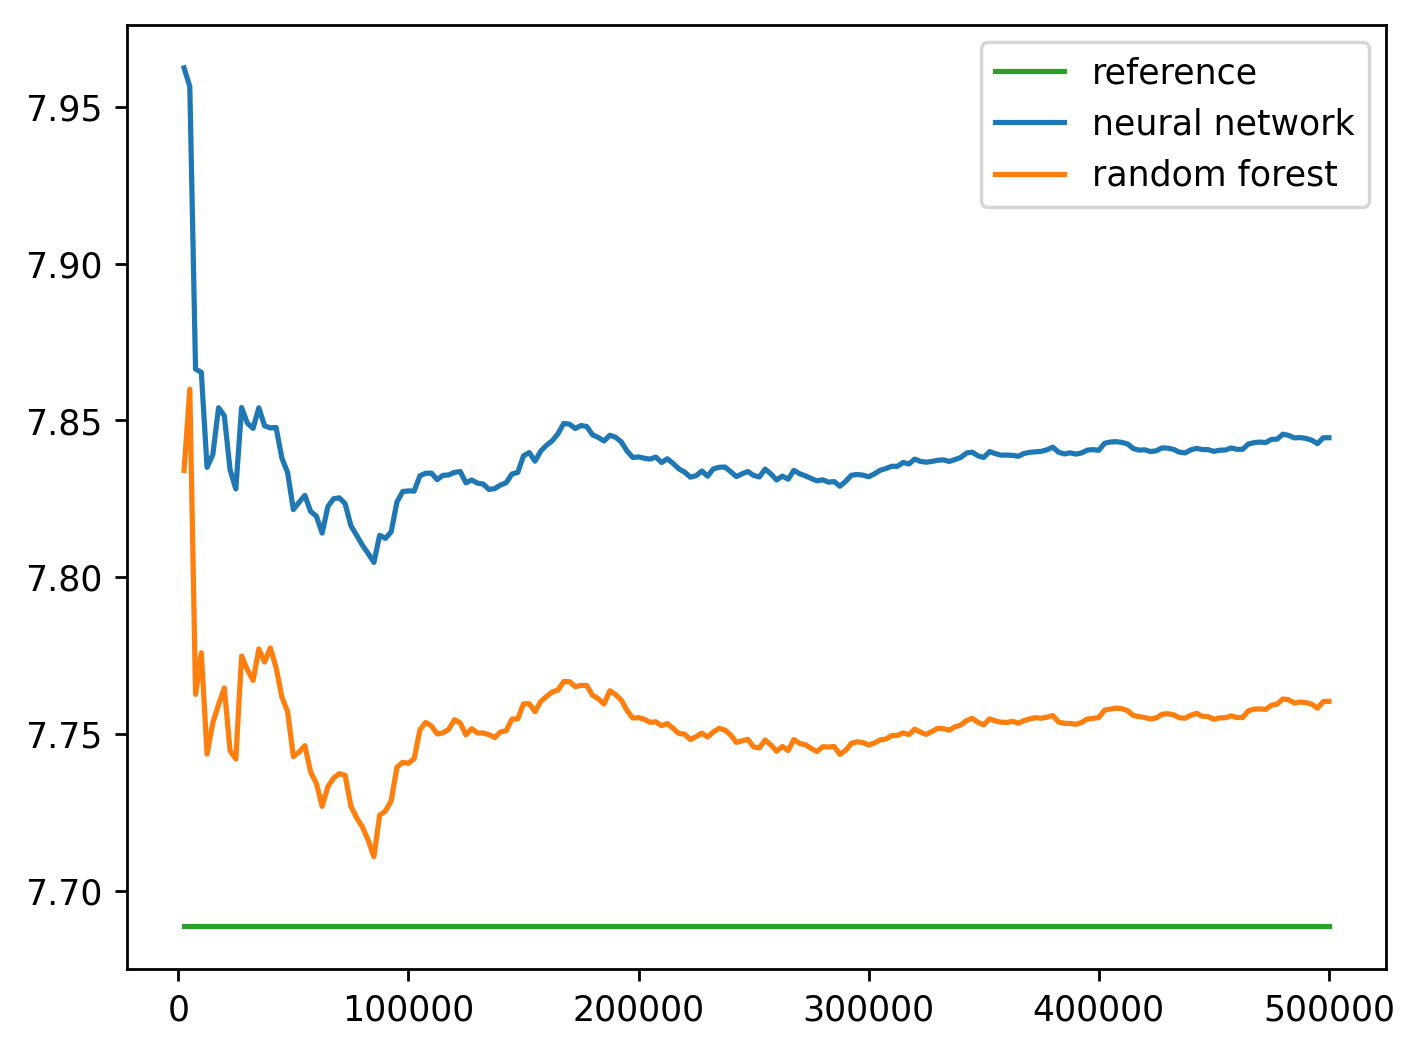

In [24]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(steps,np.full(len(steps),7.689), color='tab:green')
plt.plot(steps,GlueVaR_hat_NN, color='tab:blue')
plt.plot(steps,GlueVaR_hat_RF, color='tab:orange')
plt.legend(['reference', 'neural network', 'random forest'])
plt.show()

Plots showing the fit of the random forest and the neural network. The $x$-axes show $S_\tau$.

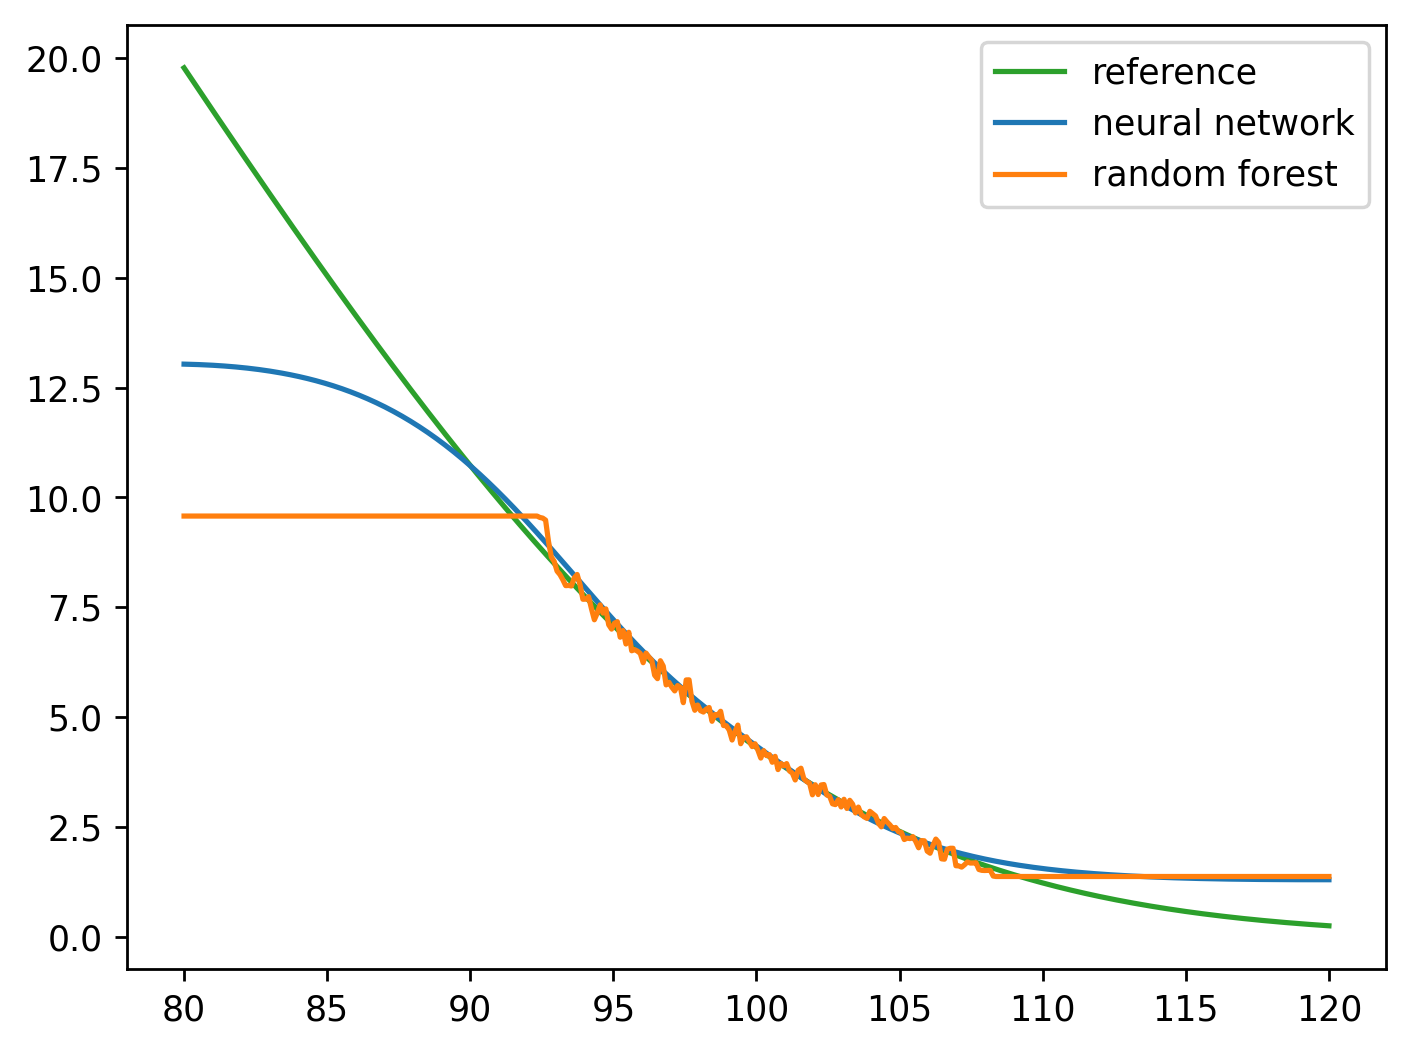

In [25]:
P_T_true = lambda x: K*np.exp(-r*(T-tau)) * stats.norm.cdf(-(np.log(x/K)+(r-0.5*sigma**2)*(T-tau))/(sigma*np.sqrt(T-tau))) - x*stats.norm.cdf(-(np.log(x/K)+(r+0.5*sigma**2)*(T-tau))/(sigma*np.sqrt(T-tau)))

x = np.linspace(80, 120, 400)

plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(x, P_T_true(x), color='tab:green')
plt.plot(x, model.predict(x)[:,0], color='tab:blue')
plt.plot(x, rfr.predict(x.reshape((-1,1))), color='tab:orange')
plt.legend(['reference', 'neural network', 'random forest'])
plt.show()

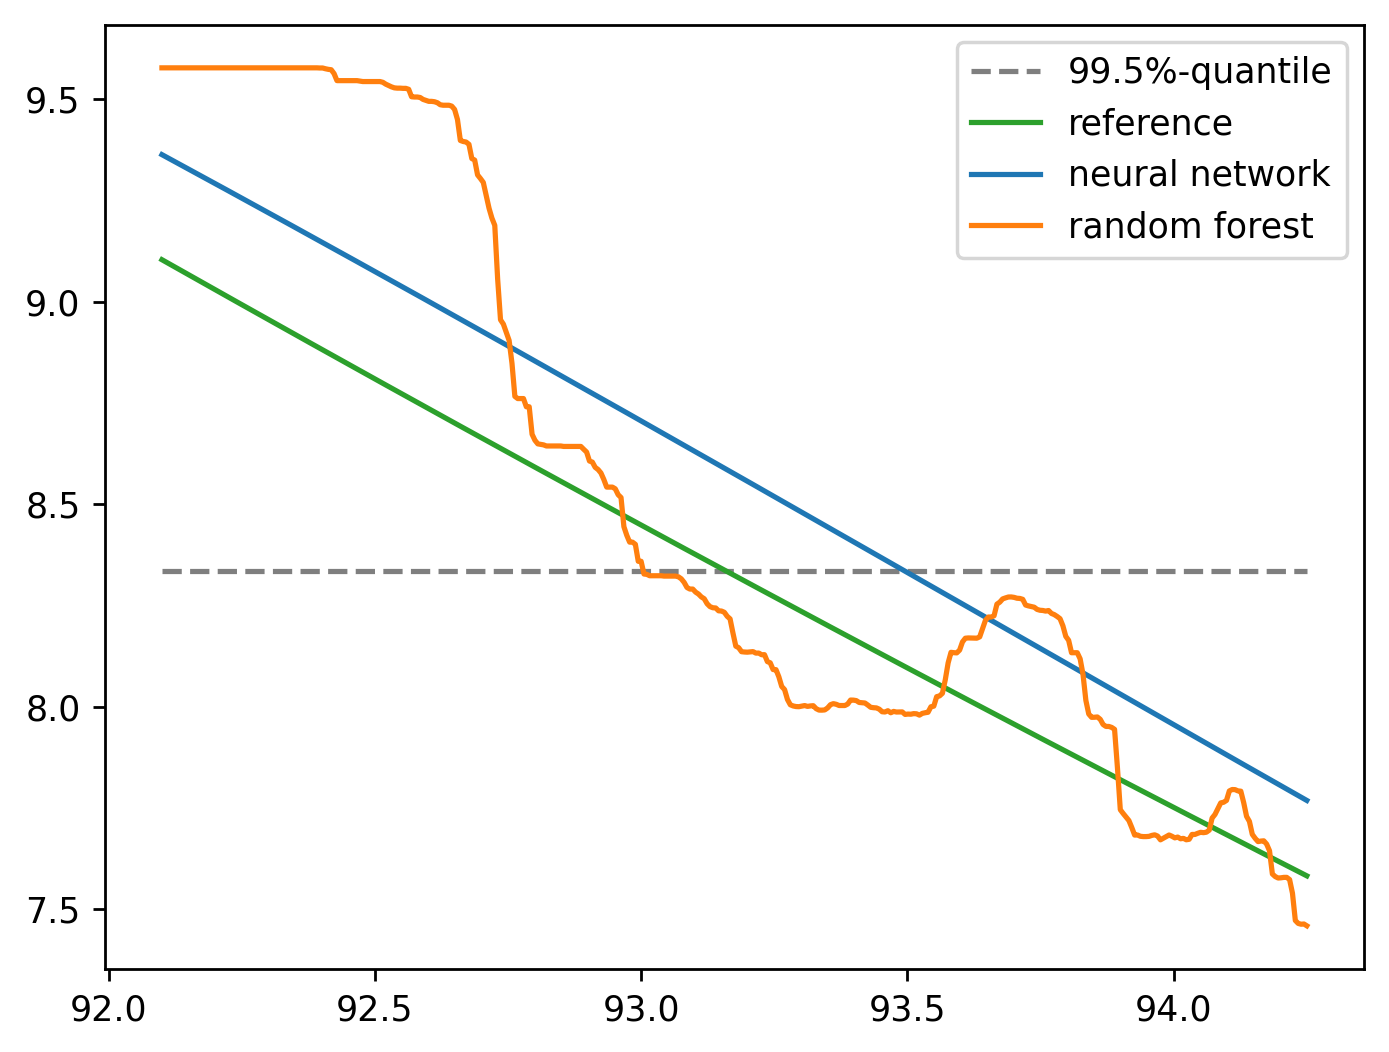

In [26]:
x = np.linspace(92.1, 94.25, 400)

plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(x, np.full(len(x),8.3356), color='tab:grey', linestyle='--')
plt.plot(x, P_T_true(x), color='tab:green')
plt.plot(x, model.predict(x)[:,0], color='tab:blue')
plt.plot(x, rfr.predict(x.reshape((-1,1))), color='tab:orange')
plt.legend(['99.5%-quantile','reference','neural network','random forest'])
plt.show()

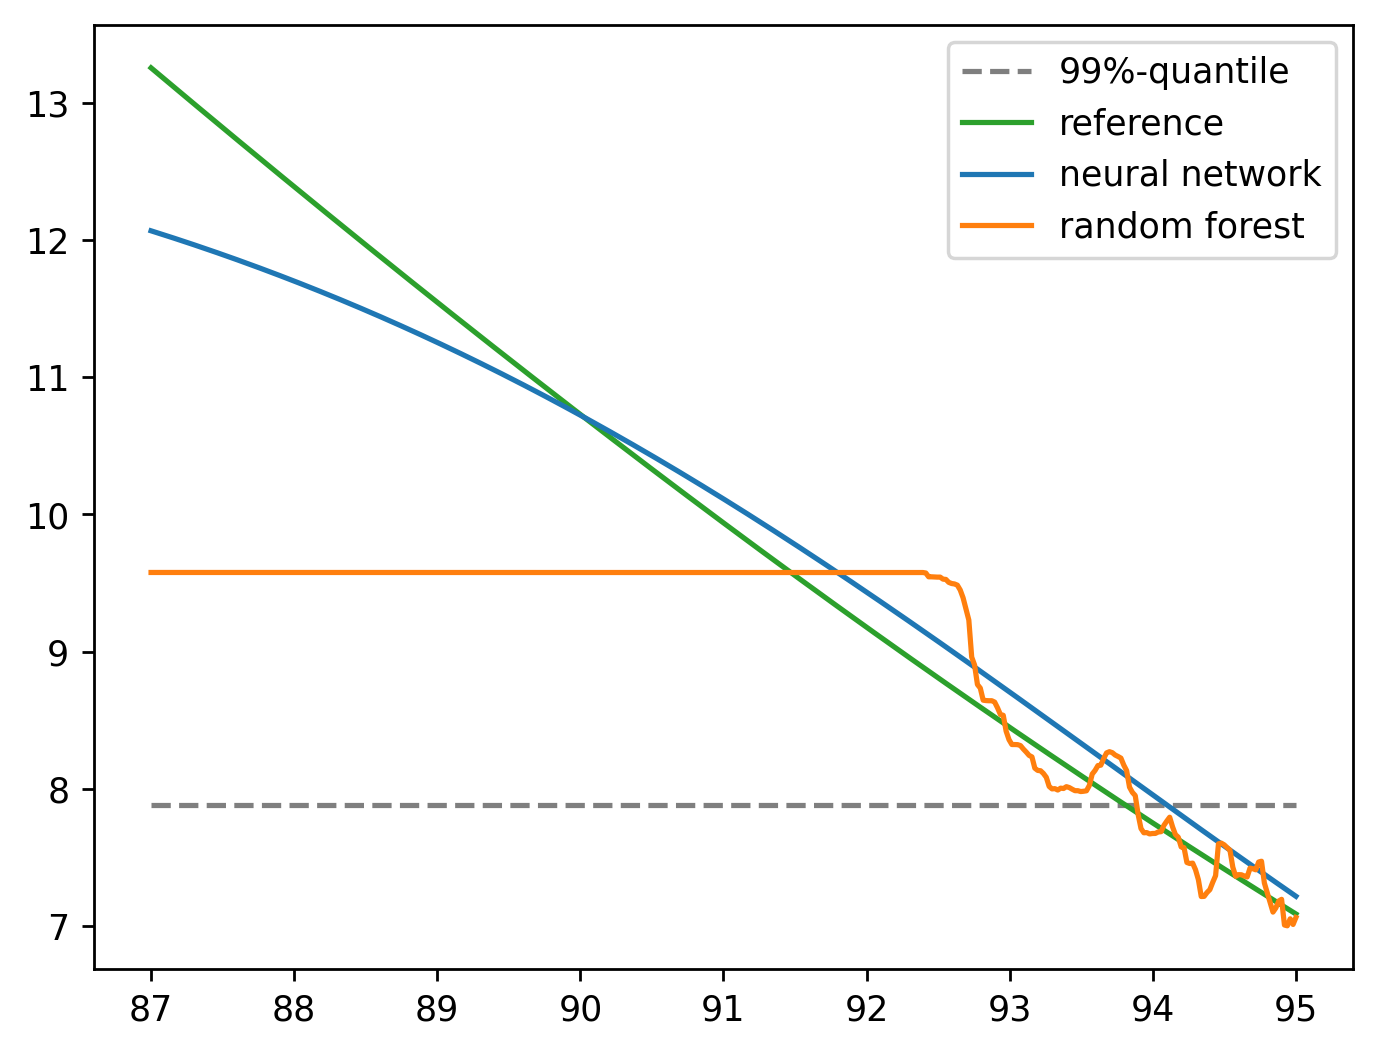

In [27]:
x = np.linspace(87, 95, 400)

plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(x, np.full(len(x),7.8844), color='tab:grey', linestyle='--')
plt.plot(x, P_T_true(x), color='tab:green')
plt.plot(x, model.predict(x)[:,0], color='tab:blue')
plt.plot(x, rfr.predict(x.reshape((-1,1))), color='tab:orange')
plt.legend(['99%-quantile','reference','neural network','random forest'])
plt.show()

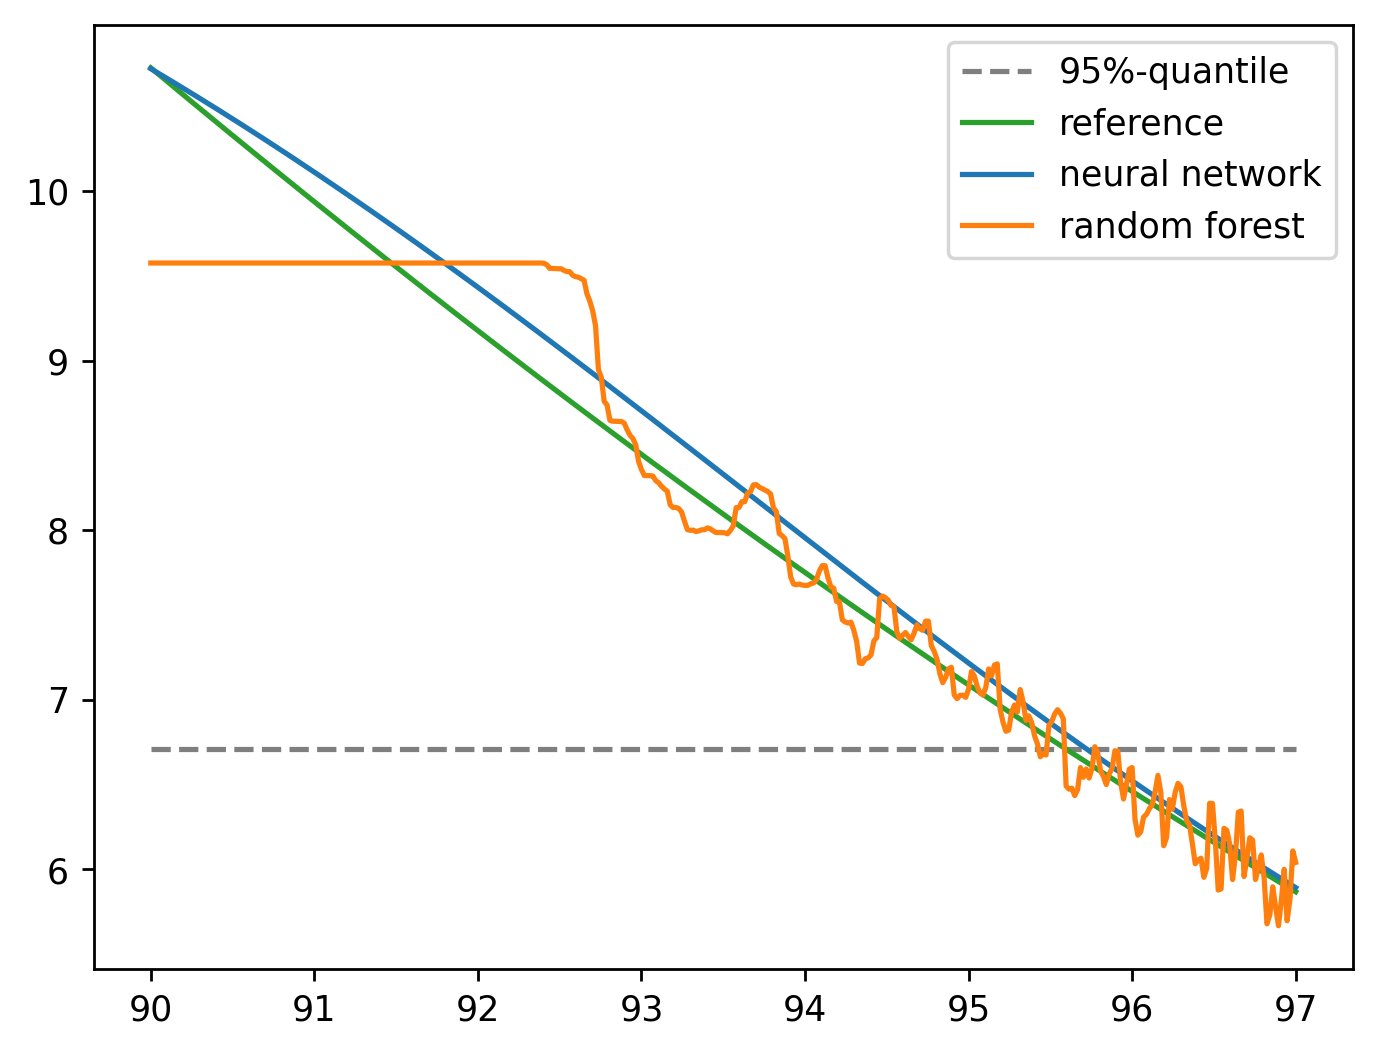

In [28]:
x = np.linspace(90, 97, 400)

plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(x, np.full(len(x),6.7104), color='tab:grey', linestyle='--')
plt.plot(x, P_T_true(x), color='tab:green')
plt.plot(x, model.predict(x)[:,0], color='tab:blue')
plt.plot(x, rfr.predict(x.reshape((-1,1))), color='tab:orange')
plt.legend(['95%-quantile', 'reference', 'neural network', 'random forest'])
plt.show()

In [29]:
#Saving the computed risk measure estimators such that they can be compared to estimators produced with usage of the importance sampling procedure in another notebook (single_run_eval.ipynb)
joblib.dump(VaR_hat_NN, filepath+'VaR_hat_NN.joblib')
joblib.dump(ES_hat_NN, filepath+'ES_hat_NN.joblib')
joblib.dump(GlueVaR_hat_NN, filepath+'GlueVaR_hat_NN.joblib')
joblib.dump(VaR_hat_RF, filepath+'VaR_hat_RF.joblib')
joblib.dump(ES_hat_RF, filepath+'ES_hat_RF.joblib')
joblib.dump(GlueVaR_hat_RF, filepath+'GlueVaR_hat_RF.joblib')

['/pfs/data5/home/ul/ul_student/ul_ynv73/Put/saved_mix/GlueVaR_hat_RF.joblib']